# Decision Tree Experiments

In [137]:
from sklearn.tree import DecisionTreeClassifier
import numpy as np
import pandas as pd
import os
from sklearn.tree._tree import TREE_LEAF
from sklearn.externals.six import StringIO
from IPython.display import Image
from sklearn.tree import export_graphviz
import pydotplus
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.tree._tree import TREE_LEAF
from sklearn.externals.six import StringIO
from IPython.display import Image
from sklearn.tree import export_graphviz
import pydotplus
from numpy import loadtxt
from sklearn.ensemble import RandomForestClassifier
import os
from sklearn.decomposition import PCA

def get_num_leaves(model):
    return sum(model.tree_.children_left < 0)

def print_decision_tree(model):
    # Taken from https://medium.com/@rnbrown/creating-and-visualizing-decision-trees-with-python-f8e8fa394176
    dot_data = StringIO()

    export_graphviz(model, out_file=dot_data,   
                    feature_names = train_df.columns[1:10],
                    filled=True, rounded=True,
                    special_characters=True)
    graph = pydotplus.graph_from_dot_data(dot_data.getvalue())
    return Image(graph.create_png())

# Modifed from David Dale's solution at https://stackoverflow.com/questions/49428469/pruning-decision-trees.
def prune_tree(model, threshold):
    prune_index(model.tree_, 0, threshold)
    return model

def prune_index(inner_tree, index, threshold):
    # Recursively call prune_index until you hit the leaf nodes.
    if inner_tree.children_left[index] != TREE_LEAF:
        prune_index(inner_tree, inner_tree.children_left[index], threshold)
        prune_index(inner_tree, inner_tree.children_right[index], threshold)
    if inner_tree.value[index].sum() < threshold:
        # turn node into a leaf by "unlinking" its children
        inner_tree.children_left[index] = TREE_LEAF
        inner_tree.children_right[index] = TREE_LEAF
current_dir  = os.getcwd()

In [73]:
allData = pd.read_csv(current_dir+ '/data/allData.tsv', sep='\t')
allData.head()

userID  age gender  movieID                              name  year  \
0     747    1      F     1193  One Flew Over the Cuckoo's Nest   1975   
1     747    1      F      661        James and the Giant Peach   1996   
2     747    1      F     2804               Christmas Story, A   1983   
3     747    1      F      919                Wizard of Oz, The   1939   
4     747    1      F     2791                        Airplane!   1980   

      genre1      genre2   genre3  rating  
0      Drama         NaN      NaN       5  
1  Animation  Children's  Musical       3  
2     Comedy       Drama      NaN       5  
3  Adventure  Children's    Drama       4  
4     Comedy         NaN      NaN       4

In [74]:
predict_df = pd.read_csv(current_dir+ '/data/predict.csv')
movies = pd.read_csv('/Users/Nathan/Documents/STATS535/MovieReccomendation/data/movies.tsv', sep='\t')
users = pd.read_csv('/Users/Nathan/Documents/STATS535/MovieReccomendation/data/users.csv')
#predict_df.head()
predict = predict_df.merge(movies, on=['movieID'])
predict = predict.merge(users, on =['userID'])
predict = predict[[
'userID','age','gender','movieID','name','year','genre1','genre2','genre3','rating']]
predict.head()

userID  age gender  movieID                                    name  year  \
0    3073   35      F     2997                   Being John Malkovich   1999   
1    2083   25      F      788                   Nutty Professor, The   1996   
2    5949   35      F     3386                                    JFK   1991   
3      70   25      M     3386                                    JFK   1991   
4    4227   18      M     2683  Austin Powers: The Spy Who Shagged Me   1999   

   genre1   genre2  genre3  rating  
0  Comedy      NaN     NaN       0  
1  Comedy  Romance  Sci-Fi       0  
2   Drama  Mystery     NaN       0  
3   Drama  Mystery     NaN       0  
4  Comedy      NaN     NaN       0

In [75]:
genre_dict = {}
name_dict = {}
nm = 0
genre = 0
for val in movies.values:
    name_dict[val[1]] = nm
    nm+=1
    if val[3] not in genre_dict:
        genre_dict[val[3]] = genre
        genre +=1
    if val[4] not in genre_dict:
        genre_dict[val[4]] = genre
        genre +=1

print(genre_dict)

{nan: 6, 'Animation': 0, 'Thriller': 11, 'Drama': 5, 'Musical': 18, 'Film-Noir': 17, 'Horror': 9, 'Comedy': 3, "Children's": 1, 'Mystery': 12, 'Sci-Fi': 10, 'Western': 15, 'War': 16, 'Fantasy': 14, 'Adventure': 2, 'Action': 7, 'Crime': 8, 'Documentary': 13, 'Romance': 4}


In [76]:
def encode(df):
    new_name = df['name'].map(name_dict)
    df['name'] = new_name
    new_g1 = df['genre1'].map(genre_dict)
    df['genre1'] = new_g1
    new_g2 = df['genre2'].map(genre_dict)
    df['genre2'] = new_g2
    new_g3 = df['genre3'].map(genre_dict)
    df['genre3'] = new_g3
    df = pd.get_dummies(df, columns=['gender'])
    return df

train_df = encode(allData)
predict = encode(predict)

In [77]:
train_df.head()

userID  age  movieID  name  year  genre1  genre2  genre3  rating  gender_F  \
0     747    1     1193   386  1975       5       6       6       5         1   
1     747    1      661   200  1996       0       1      18       3         1   
2     747    1     2804  1042  1983       3       5       6       5         1   
3     747    1      919   293  1939       2       1       5       4         1   
4     747    1     2791  1037  1980       3       6       6       4         1   

   gender_M  
0         0  
1         0  
2         0  
3         0  
4         0

In [94]:
msk = np.random.rand(len(train_df)) < 0.8
test = train_df[msk]
val = train_df[~msk]
X_train = test[['userID','movieID','name','year','genre1','genre2','genre3','gender_F','gender_M']].values
y_train = test[['rating']].values
X_val = val[['userID','movieID','name','year','genre1','genre2','genre3','gender_F','gender_M']].values
y_val = val[['rating']].values

In [102]:
# Modifed from David Dale's solution at https://stackoverflow.com/questions/49428469/pruning-decision-trees.
def prune_tree(model, threshold):
    prune_index(model.tree_, 0, threshold)
    return model

def prune_index(inner_tree, index, threshold):
    # Recursively call prune_index until you hit the leaf nodes.
    if inner_tree.children_left[index] != TREE_LEAF:
        prune_index(inner_tree, inner_tree.children_left[index], threshold)
        prune_index(inner_tree, inner_tree.children_right[index], threshold)
    if inner_tree.value[index].sum() < threshold:
        # turn node into a leaf by "unlinking" its children
        inner_tree.children_left[index] = TREE_LEAF
        inner_tree.children_right[index] = TREE_LEAF

In [106]:
max_depth = 49
max_prune = 250
scores = []


for depth in range(1,max_depth):
    for threshold in range(0,max_prune,50):
        t = DecisionTreeClassifier(max_depth=depth, random_state=0).fit(X_train, y_train)
        t = prune_tree(t, threshold)
        scores.append([threshold,depth,t.score(X_val,y_val)])

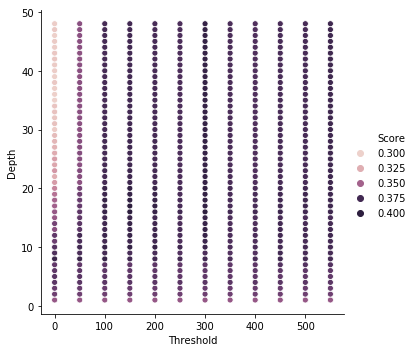

In [107]:
tree_df = pd.DataFrame(scores, columns =['Threshold', 'Depth','Score']) 
sns.relplot(x='Threshold',y='Depth',hue='Score',kind="scatter",data=tree_df)

In [111]:
highest = np.argmax([s[2]for s in scores])
print(scores[highest])

[150, 16, 0.3809597523219814]


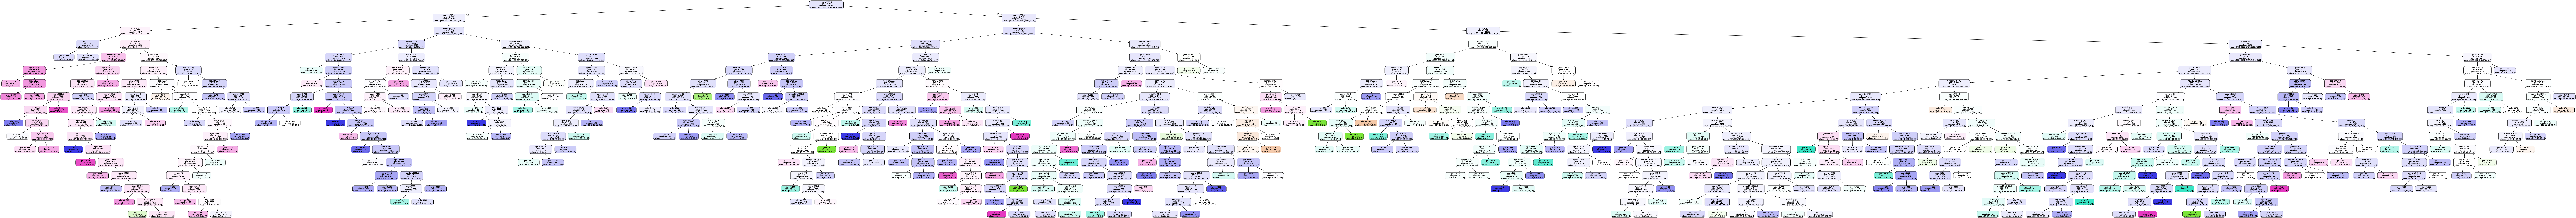

In [122]:
best_tree = DecisionTreeClassifier(max_depth=16, random_state=0).fit(X_train, y_train)
best_tree = prune_tree(best_tree, 150)
print_decision_tree(best_tree)

# Random Forrest

In [134]:
rf_scores = []
for depth in range(1,max_depth):
    rf = RandomForestClassifier(max_depth=depth,random_state=0).fit(X_train, y_train)
    rf_scores.append([depth, rf.score(X_val,y_val)])

print(rf_scores[np.argmax([s[1] for s in rf_scores])])

/Users/Nathan/Library/Python/3.5/lib/python/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/ipykernel_launcher.py:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/Nathan/Library/Python/3.5/lib/python/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/ipykernel_launcher.py:3: DataConversionWarning: A column-vector y was passed when a 1d arr

/Users/Nathan/Library/Python/3.5/lib/python/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/ipykernel_launcher.py:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/Nathan/Library/Python/3.5/lib/python/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/ipykernel_launcher.py:3: DataConversionWarning: A column-vector y was passed when a 1d arr

/Users/Nathan/Library/Python/3.5/lib/python/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/ipykernel_launcher.py:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/Nathan/Library/Python/3.5/lib/python/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/ipykernel_launcher.py:3: DataConversionWarning: A column-vector y was passed when a 1d arr

/Users/Nathan/Library/Python/3.5/lib/python/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/ipykernel_launcher.py:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/Nathan/Library/Python/3.5/lib/python/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/ipykernel_launcher.py:3: DataConversionWarning: A column-vector y was passed when a 1d arr

[11, 0.38390092879256965]


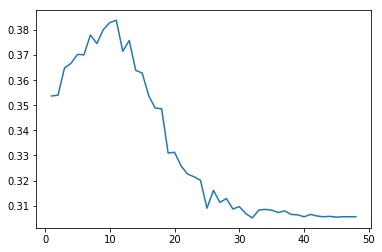

In [136]:
plt.plot([i for i in range(1,max_depth)],[s[1] for s in rf_scores])

# PCA with nearest neighbors approach

In [139]:
current_dir  = os.getcwd()
movies_df = pd.read_csv(current_dir + '/data/movies.tsv', sep='\t')   
ratings_df = pd.read_csv(current_dir + '/data/ratings.csv')
R_df = ratings_df.pivot(index = 'userID', columns ='movieID', values = 'rating')

users_mean=np.array(R_df.mean(axis=1))
R_demeaned=R_df.sub(users_mean, axis=0)
R_demeaned=R_demeaned.fillna(0).values
R_df = pd.DataFrame
R_df.head()

movieID  1     2     3     4     5     6     7     8     9     12    ...   \
userID                                                               ...    
4         NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  ...    
5         NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  ...    
6         NaN   NaN   NaN   NaN   NaN   4.0   NaN   NaN   NaN   NaN  ...    
15        NaN   NaN   NaN   NaN   NaN   5.0   NaN   NaN   NaN   NaN  ...    
17        NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  ...    

movieID  3943  3944  3945  3946  3947  3948  3949  3950  3951  3952  
userID                                                               
4         NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  
5         NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  
6         NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  
15        NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  
17        NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  

[5 rows x 1465 columns]

In [221]:
def take_second(elem):
    return elem[1]

def find_closest_points(p,n):
    closest = []
    i = 0
    for point in points:
        if set(point) != set(p):
            dist = np.linalg.norm(point-p)
            closest.append([i, dist])
        i+=1
    closest = sorted(closest, key = take_second)
    return closest[:n]

def find_closest_point(p):
    min_dist = 9999999999
    min_index = 0
    i = 0
    for point in points:
        if set(point) != set(p):
            dist = np.linalg.norm(point-p)
            if dist < min_dist:
                min_dist = dist
                min_index = i
        i+=1
    userID = R_df.index[min_index]
    return min_index, userID

def find_favorite_movies(index):
    person = R_df.iloc[index].values
    rated_movies = []
    for i in range(len(person)):
        if not np.isnan(person[i]):
            rated_movies.append([R_df.columns[i], person[i]])
    temp_df = pd.DataFrame(rated_movies, columns=['movieID','rating'])
    temp_df = temp_df.merge(movies, on="movieID")
    temp_df = temp_df.sort_values('rating', ascending=False)
    return temp_df


# Select User Index And Display Their Favorite Movies

In [244]:
pca = PCA(n_components=15)
points = pca.fit_transform(R_demeaned)

In [262]:
user_index = 146
user=find_favorite_movies(user_index)
user.head()

movieID  rating                 name  year  genre1   genre2 genre3
0     1228     5.0         Raging Bull   1980   Drama      NaN    NaN
3     2804     5.0  Christmas Story, A   1983  Comedy    Drama    NaN
4     3386     5.0                 JFK   1991   Drama  Mystery    NaN
1     1952     4.0     Midnight Cowboy   1969   Drama      NaN    NaN
2     2329     4.0  American History X   1998   Drama      NaN    NaN

# Find Closest Points and Display Theit Highest Rated

In [264]:
pts = find_closest_points(points[user_index],2)
frames = [find_favorite_movies(pt[0]) for pt in pts]
favs = pd.concat(frames)
favs = favs.sort_values('rating', ascending=False)
favs = favs.drop('rating', axis=1)
favs.head()

movieID                name  year     genre1    genre2 genre3
0       86       White Squall   1996  Adventure     Drama    NaN
2     2772  Detroit Rock City   1999     Comedy       NaN    NaN
3     3863          Cell, The   2000     Sci-Fi  Thriller    NaN
1     2759               Dick   1999     Comedy       NaN    NaN
1     1911    Doctor Dolittle   1998     Comedy       NaN    NaN

## Tesorflow conv net!!
### Creating distribution over all movies for scores
For creating a distribution, how about I plug in all of the different values into the persons data, so if its movie 323 I will put a 0 then transform it using th pca, then I will do this for all values 0-5. Then I will see which lies closest in the n dim space to the original point and greedily select that as their rating. I will try doing this for all values in the test set and see how this approach performs.

So in order to do this I need to remove some of the informatio nabout each users movie watching tendencies. So first I will create a train and test set by going through 20% of the users and select any one movie which they rated above 0 randomly. Then I will put the user index, movie index, and actual rating into the test set and then use the remaining for the train set. Also only do this for users which have more than one rated movie.

After I set up the train/test sets I will select each user from the test set, then retreive their ratings from the training set. I will then take the movie index and change the value at that index in the range 1-5. Then I will pass the new user ratings through the pca transformer. The resulting arrays will then be compared to the original test set to see how close they are by elucidean distance. Then greedily select the point closest and chose that as the rating.

Do this process for all of the points and then evaluate it based on bith number of correct, and also mean absolute deviation.


## Switch to regression trees
## Boosted Regression Tree

In [405]:
def find_movie_prob(movies):
    probabilities =  np.zeros(len(movies))
    not_zero = 0
    for i in range(len(movies)):
        if movies[i] >0:
            not_zero += 1
            probabilities[i] = 1
    if not_zero > 1:
        return probabilities/not_zero
    else:
        return []

In [406]:
test = []
train_demeaned = R_demeaned
np.random.seed(1)
choices = np.random.choice(len(R_demeaned),round(len(train_demeaned)*.1))
for index in choices:
    movies = train_demeaned[index]
    probs = find_movie_prob(movies)
    if len(probs) > 0:
        probs = find_movie_prob(movies)
        movie_index = np.random.choice(len(movies),1, p=probs)
        actual_rating = movies[movie_index[0]]
        test.append([index,movie_index[0],actual_rating+users_mean[index]])
        train_demeaned[index][movie_index[0]] -= (train_demeaned[index][movie_index[0]]+users_mean[index]) 

In [407]:
def calc_rating(mod, movie_ind, arr,points):
    temp = []
    for i in range(1,6):
        arr[movie_ind] = i
        l = mod.transform([arr])
        temp.append(np.linalg.norm(l-points[movie_ind]))
    return np.argmin(temp)+1  

In [408]:
graph_y = []
MAD = []
for i in range(1, 20):
    pca = PCA(n_components=i, random_state=0)
    points = pca.fit_transform(train_demeaned)
    correct = 0
    ad = []
    for t in test:
        rating = calc_rating(pca, t[1],train_demeaned[t[1]] ,points)
        if rating == t[2]:
            correct += 1
        ad.append(abs(rating-t[2]))
    MAD.append(np.mean(ad))
    graph_y.append(correct/len(test))

In [409]:
print(np.max(graph_y), np.argmax(graph_y)+1, graph_y[np.argmax(MAD)])
print(np.min(MAD), np.argmax(MAD)+1, MAD[np.argmax(graph_y)])

0.5294117647058824 2 0.47058823529411764
0.5533769063180828 1 0.6122004357298475


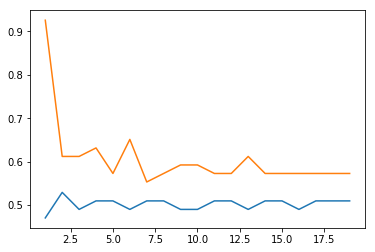

In [410]:
plt.plot(range(1,20),graph_y)
plt.plot(range(1,20),MAD)

In [411]:
print(np.argmin(np.asarray(MAD)-np.asarray(graph_y)))

6


## Notes
The varying PCA approach works well. Has the lowest MAD and highest accuracy of any technique I've used thus far.
The number of components which seems to work the best is 3. It acheives a classificaiton accuracy of 0.5294117647058824 and a MAD of 0.5533769063180828.

Best n_components:
6